In [5]:
using Random, DataFrames, Statistics, LinearAlgebra, Plots, Distributions, ShiftedArrays, StatsPlots, MLBase
using JuMP, Gurobi
using RollingFunctions, CSV

const GRB_ENV = Gurobi.Env()

Academic license - for non-commercial use only - expires 2021-07-08


Gurobi.Env(Ptr{Nothing} @0x00007f8c41ff6600, false, 0)

In [531]:
df_ret = DataFrame(CSV.File("ret_spfinal.csv", header=1))
ret_tot = Matrix(df_ret)[:,2:end]
t_tot, n_tot = size(ret_tot)

# SELECTING RANDOMLY A RESTRICTED NUMBER OF ASSET
n_universe = 150
l_asset = unique(rand(1:n_tot, n_universe))
ret_r = zeros(t_tot)
for k=1:n_tot
    if k in l_asset
        ret_r = hcat(ret_r, ret_tot[:,k])
    end
end
ret_r  = ret_r[:, 2:end]; 
t_window, n_universe = size(ret_r)

# GENERATE MULTI-VARIATE GAUSSIAN BASED ON STATS
vec_mu = mean(ret_r, dims=1)
vec_mu = reshape(vec_mu, n_universe, 1)[:,1]
mat_cov = cov(ret_r);
d = MvNormal(vec_mu, mat_cov);
ret = reshape(rand(d, t_window), (t_window, n_universe));
axis = 1:t_window;

size(ret)

(137, 130)

In [155]:
#mu = 0
#sig = 0.15

#t_window = 100
#axis = 1:t_window;
#n_universe = 100

#ret = rand(Normal(mu, sig), (t_window, n_universe))
#ret = ret .- median(ret, dims=2)

#size(ret)

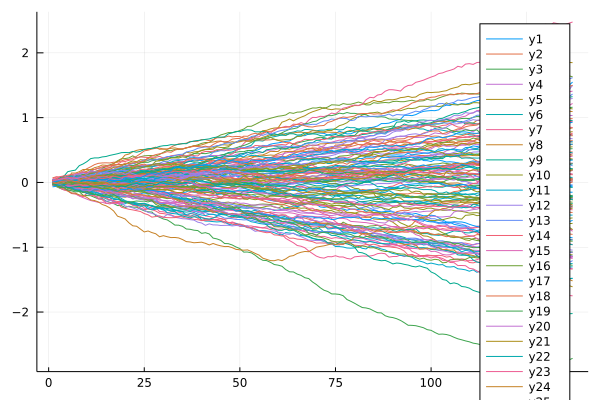

In [532]:
plot(axis, cumsum(ret, dims=1))

acc: 0.49466591802358223

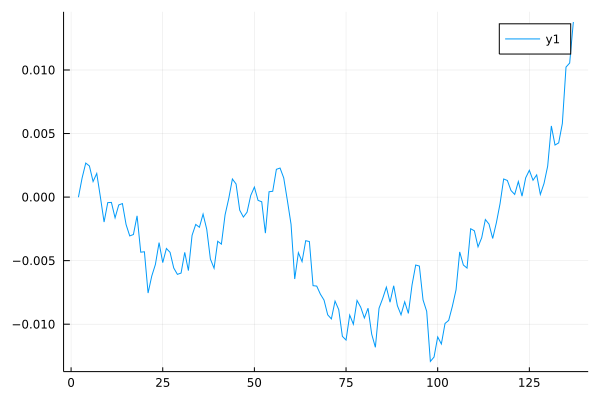

In [535]:
" random pnl "

p = 0.5
x = rand(Binomial(1,p), (t_window, n_universe))
pred = 2 .* x  .- 1

pos = pred ./ sum(abs.(pred), dims=2)
pos = pos .- mean(pos, dims=2)
pnl = sum(lag(pos, default = NaN) .* ret, dims=2);

v_gt = vcat(Int.(sign.(ret))...)
v_pred =  vcat(Int.(sign.(pred))...)
print("acc: ", correctrate(v_gt, v_pred))

plot(axis[2:t_window], cumsum(pnl[2:t_window]))



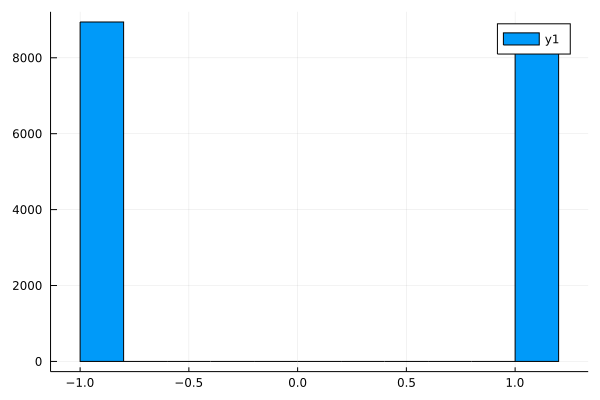

In [536]:
histogram(vcat(pred...))

acc: 0.5233597285067874
SR 8.278359147588157
TO 103.89530810788041
BIAS (bps): 7.897914257260723
BIAS / TO (bps) 7.601800698314373
SR net 6.081075072528114


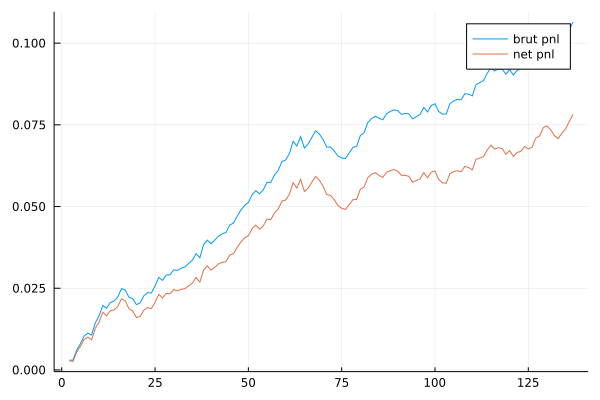

In [853]:
acc_level = 0.53

pred = sign.(lead(copy(ret))); #tomorrow's return: shift -1
ind = rand(Binomial(1, acc_level), (t_window, n_universe));
size(ind)
pred_new = copy(pred)
pred_new[ind .==0] .= -pred[ind .==0];

y_target = vcat(Int.(sign.(lead(ret)[1:end-1,:]))...) # gt of tom's returns
y_pred =  vcat(Int.(sign.(pred_new[1:end-1,:]))...);
println("acc: ", correctrate(y_target, y_pred))

pos_ini = pred_new ./ sum(abs.(pred), dims=2)
pos_ini = pos_ini .- mean(pos_ini, dims=2)
pnl_ini = sum(lag(pos_ini, default = NaN) .* ret, dims=2);

sr = mean(pnl_ini[2:end]) / std(pnl_ini[2:end]) * 15.87
println("SR ", sr)

to = sum(sum(abs.(diff(pos_ini, dims=1)), dims=2)[1:end-1]) ./ sum(sum(abs.(pos_ini), dims=2)[1:end-1])
println("TO ", to*100)

pos_ini[ismissing.(pos_ini)] .= 0
bias = sum(pnl_ini[2:end]) ./ sum(sum(abs.(pos_ini), dims=2), dims=1)[1] * 10^4
println("BIAS (bps): ", bias)

println("BIAS / TO (bps) ", bias / to)

c = 2
pnl_ini_net = pnl_ini .- to * c * 10^-4

sr = mean(pnl_ini_net[2:end]) / std(pnl_ini_net[2:end]) * 15.87
println("SR net ", sr)




""" adding a notion of predicted level: option 1: target level => as if we could acces the gt values"""

w = 10
level_target = lead(abs.(ret)) #tomorrow's intensity
ret_pred_target = level_target[w:end-1,:] .* pred_new[w:end-1,:];
pos_ini_target = pos_ini[w:end-1,:]



plot(axis[2:t_window], [cumsum(pnl_ini[2:t_window]), cumsum(pnl_ini_net[2:t_window], dims=1)],
    labels=["brut pnl" "net pnl"])


mean_acc: 0.5264082374318597

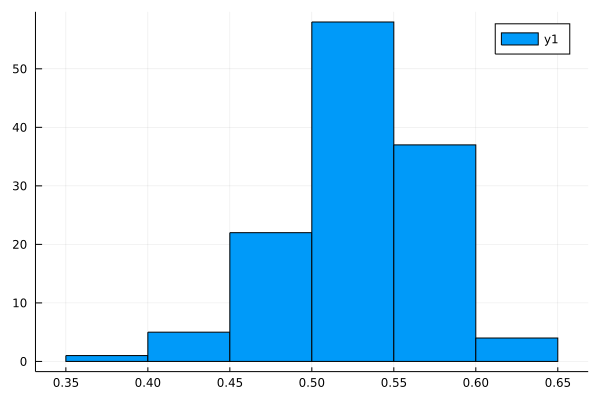

In [664]:
""" pred = tomrrow's return """

l_acc = []
for k=1:t_window -10
    pred_sign = Int.(pred_new[k,:])
    gt_sign = Int.(sign.(ret[k+1,:]))
    acc = correctrate(gt_sign, pred_sign)
    append!(l_acc, acc)
end
print("mean_acc: ", mean(l_acc))
histogram(l_acc)

In [499]:
""" adding a notion of predicted level: option 1: moving average"""

w = 10
level_mean = zeros(size(ret))
level_mean = level_mean[w:end,:]
for k=1:size(ret)[2]
    level_mean[:,k] = rollmean(abs.(ret)[:,k], w)
end

ret_pred = level_mean[1:end-1,:] .* pred_new[w:end-1,:]; # multiply the level by the sign
pos_ini_target = pos_ini[w:end-1,:];

In [392]:
""" adding a notion of predicted level: option 1: target level => as if we could acces the gt values"""

w = 10
level_target = lead(abs.(ret))
ret_pred_target = level_target[w:end-1,:] .* pred_new[w:end-1,:];
pos_ini_target = pos_ini[w:end-1,:]
ret_pred_target;

# single period opt

In [854]:
function opt_pf(v_mu, mat_sig, dc_param)

    lambda = dc_param["lambda"]

    model = Model(Gurobi.Optimizer)
    #model = Model(() -> Gurobi.Optimizer(GRB_ENV))

    @variable(model, x[i=1:n_universe])
    @variable(model, y[i=1:n_universe])
    
    # AVOID CONCENTRATION
    @constraint(model, [i=1:n_universe], y[i] >= dc_param["level_min"])
    @constraint(model, [i=1:n_universe], y[i] <= dc_param["level_max"])
    
    # INVEST 1 DOLLARS
    @constraint(model,[i=1:n_universe], y[i]>=x[i])
    @constraint(model,[i=1:n_universe], y[i]>=-x[i])
    @constraint(model, sum(y[i] for i=1:n_universe) == 1)
    
    # BEING DOLLAR NEUTRAL
    @constraint(model, sum(x[i] for i=1:n_universe) == 0)
    

    @objective(model, Max, v_mu'x - lambda * sum(x[i] * (mat_sig*x)[i] for i=1:n_universe))

    optimize!(model);

    a = getvalue.(x);
    return a
end

function opt_pf_to(v_mu, mat_sig, dc_param, x_prev)

    lambda = dc_param["lambda"]

    model = Model(Gurobi.Optimizer)
    #model = Model(() -> Gurobi.Optimizer(GRB_ENV))

    @variable(model, x[i=1:n_universe])
    @variable(model, y[i=1:n_universe])
    @variable(model, t[i=1:n_universe])
    
    # AVOID CONCENTRATION
    @constraint(model, [i=1:n_universe], y[i] >= dc_param["level_min"])
    @constraint(model, [i=1:n_universe], y[i] <= dc_param["level_max"])
    
    # INVEST 1 DOLLARS
    @constraint(model,[i=1:n_universe], y[i]>=x[i])
    @constraint(model,[i=1:n_universe], y[i]>=-x[i])
    @constraint(model, sum(y[i] for i=1:n_universe) == 1)
    
    # BEING DOLLAR NEUTRAL
    @constraint(model, sum(x[i] for i=1:n_universe) == 0)
    
    # TURNOVER LEVEL
    @constraint(model, [i=1:n_universe], t[i]>=x[i] - x_prev[i])
    @constraint(model, [i=1:n_universe], t[i]>=-(x[i] - x_prev[i]))
    

    @objective(model, Max, 
        v_mu'x - lambda * sum(x[i] * (mat_sig*x)[i] for i=1:n_universe) - dc_param["cost"] * sum(t[i] for i=1:n_universe))

    optimize!(model);

    a = getvalue.(x);
    return a
end

function opt_pf_toBIS(v_mu, mat_sig, dc_param, x_prev, x_ini)

    lambda = dc_param["lambda"]

    model = Model(Gurobi.Optimizer)
    #model = Model(() -> Gurobi.Optimizer(GRB_ENV))

    @variable(model, x[i=1:n_universe])
    @variable(model, y[i=1:n_universe])
    @variable(model, t[i=1:n_universe])
    
    # AVOID CONCENTRATION
    @constraint(model, [i=1:n_universe], y[i] >= dc_param["level_min"])
    @constraint(model, [i=1:n_universe], y[i] <= dc_param["level_max"])
    
    # INVEST 1 DOLLARS
    @constraint(model,[i=1:n_universe], y[i]>=x[i])
    @constraint(model,[i=1:n_universe], y[i]>=-x[i])
    @constraint(model, sum(y[i] for i=1:n_universe) == 1)
    
    # BEING DOLLAR NEUTRAL
    @constraint(model, sum(x[i] for i=1:n_universe) == 0)
    
    # TURNOVER LEVEL
    @constraint(model, [i=1:n_universe], t[i]>=x[i] - x_prev[i])
    @constraint(model, [i=1:n_universe], t[i]>=-(x[i] - x_prev[i]))
    @constraint(model, [i=1:n_universe], sum(t[i] for i=1:n_universe) <= dc_param["to"])
    
    # TRACKING/OUTPERFORMING INITIAL PNL
    #@constraint(model, [i=1:n_universe], t[i]>=x[i] - x_prev[i])
    #@constraint(model, [i=1:n_universe], v_mu'x - v_mu'x_ini >= dc_param["bound"])
    #@constraint(model, [i=1:n_universe], v_mu'x - v_mu'x_ini <= -dc_param["bound"])
    @variable(model, b)
    @constraint(model, b >= (v_mu'x-v_mu'x_ini)^2)
    

    @objective(model, Max, 
        dc_param["alpha"] * v_mu'x - lambda * sum(x[i] * (mat_sig*x)[i] for i=1:n_universe) 
        + dc_param["outperf"] * (v_mu'x-v_mu'x_ini) - dc_param["tracking"] * b)

    optimize!(model);

    a = getvalue.(x);
    return a
end




opt_pf_toBIS (generic function with 2 methods)

In [855]:
dict_param = Dict()
dict_param["alpha"] = 1
dict_param["level_min"] = 0.000
dict_param["level_max"] = 0.01
dict_param["lambda"] = 0.2
dict_param["cost"] = 0.05
dict_param["to"] = 0.1

dict_param["outperf"] = 0
dict_param["bound"] = 0.01
dict_param["tracking"] = 0

mat_pos = zero(n_universe)
mat_cov = cov(ret)

t_trading = size(ret_pred_target)[1]

x_prev = zeros(n_universe)

for k=1:t_trading
    #v_ret = ret_pred[k,:]
    v_ret = ret_pred_target[k,:]
    #x_opt = opt_pf(v_ret, mat_cov, dict_param);
    #x_opt = opt_pf_to(v_ret, mat_cov, dict_param, x_prev);
    x_ini = pos_ini_target[k,:]
    x_opt = opt_pf_toBIS(v_ret, mat_cov, dict_param, x_prev, x_ini)
    x_prev = x_opt
    mat_pos = vcat(mat_pos, reshape(x_opt, (1, n_universe)))
end



Academic license - for non-commercial use only - expires 2021-07-08
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 912 rows, 391 columns and 18460 nonzeros
Model fingerprint: 0xe0a3259f
Model has 8515 quadratic objective terms
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [6e-09, 6e-03]
  QLMatrix range   [2e-06, 1e+00]
  Objective range  [8e-05, 6e-02]
  QObjective range [3e-09, 3e-04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+00]
  QRHS range       [2e-04, 2e-04]
Presolve removed 389 rows and 0 columns
Presolve time: 0.02s
Presolved: 657 rows, 526 columns, 10342 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.583e+04
 Factor NZ  : 4.856e+04 (roughly 1 MByte of memory)
 Factor Ops : 4.709e+06 (less than 1 second per iteration)

SR: 5.519887831383559
TO 10.697352251534006
BIAS (bps): 6.483995695176319
BIAS / TO (bps) 60.61308950770047


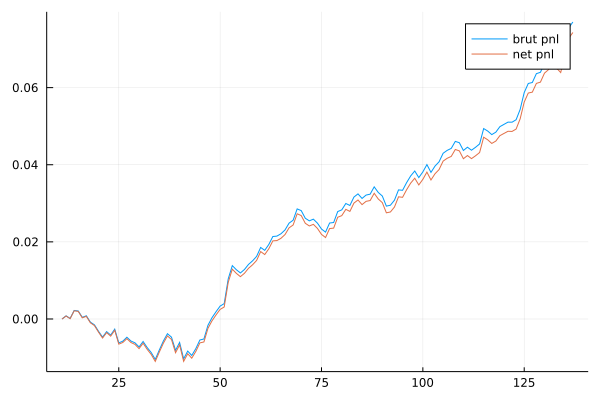

In [856]:
pnl = sum(lag(mat_pos)[2:end,:] .* ret[w:end-1,:], dims=2)
#pnl = sum(lag(mat_pos)[2:end,:] .* ret[w:end-1,:], dims=2)

sr = mean(pnl) / std(pnl) * 15.87
println("SR: ", sr)

pos = mat_pos
to = sum(sum(abs.(diff(pos, dims=1)), dims=2)[1:end-1]) ./ sum(sum(abs.(pos), dims=2)[1:end-1])
println("TO ", to*100)

bias = sum(pnl) ./ sum(sum(abs.(mat_pos), dims=2), dims=1)[1] * 10^4
println("BIAS (bps): ", bias)

println("BIAS / TO (bps) ", bias / to)

c = 2
pnl_net = pnl .- to * c * 10^-4

axis_n = 11:t_window
plot(axis_n, [cumsum(pnl, dims=1), cumsum(pnl_net, dims=1)], label = ["brut pnl" "net pnl"])

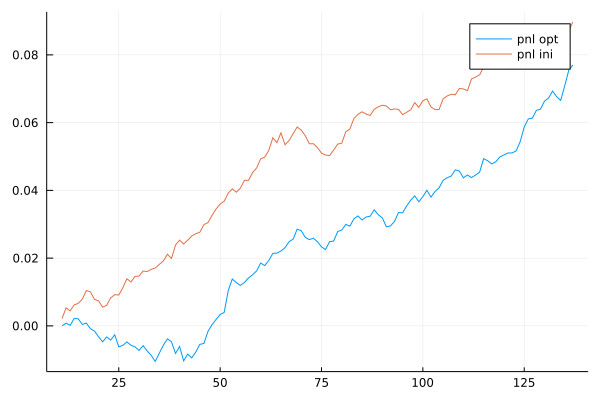

In [857]:
plot(axis_n, [cumsum(pnl, dims=1), cumsum(pnl_ini[10:end-1], dims=1)], 
    label = ["pnl opt" "pnl ini "])

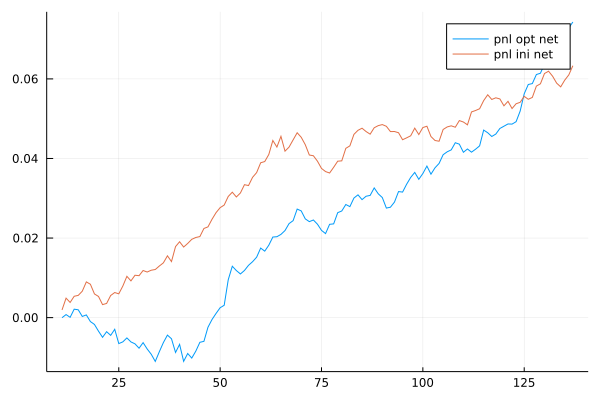

In [858]:
plot(axis_n, [cumsum(pnl_net, dims=1), cumsum(pnl_ini_net[10:end-1], dims=1)],
    label = ["pnl opt net" "pnl ini net "] )

In [859]:
cor(cumsum(pnl, dims=1), cumsum(pnl_ini[10:end-1], dims=1))

1×1 Array{Float64,2}:
 0.9503884395440658

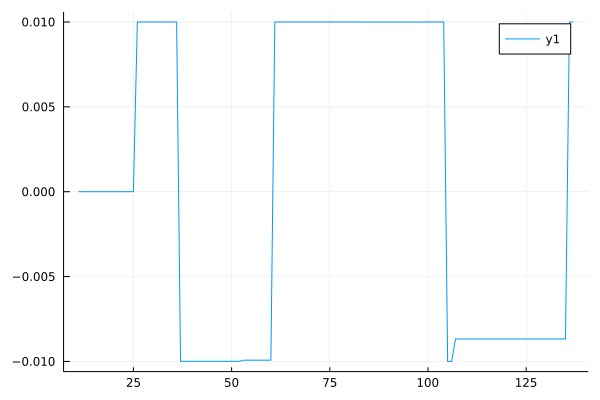

In [860]:
#maximum(mat_pos, dims=2)
n = 24
plot(axis_n, mat_pos[2:end,n])

# multi-period opt

In [861]:
function multi_opt(mat_mu, dc_ini, dc_param)
    
    n_asset, t_step = dc_ini["n_asset"],  dc_ini["t_step"]
    
    model = Model(Gurobi.Optimizer)

    @variable(model, x[t=1:t_step, i=1:n_asset])
    @variable(model, y[t=1:t_step, i=1:n_asset])
    @variable(model, f[t=1:t_step, i=1:n_asset])
    @variable(model, W[t=1:t_step])

    # INVEST 1 DOLLARS at each time step
    @constraint(model, [t=1:t_step, i=1:n_asset], y[t,i]>=x[t,i])
    @constraint(model, [t=1:t_step, i=1:n_asset], y[t,i]>=-x[t,i])
    @constraint(model, [t=1:t_step], sum(y[t,i] for i=1:n_asset) == 1);

    # BEING DOLLAR NEUTRAL at each time step
    @constraint(model, [t=1:t_step], sum(x[t,i] for i=1:n_asset) == 0)

    #CONCENTRATION
    @constraint(model, [t=1:t_step, i=1:n_asset], y[t,i] <= dc_param["level_max"])

    # WEALTH DYNAMICS
    @constraint(model, [i=1:n_asset], f[1, i] == 0)
    @constraint(model, [t=2:t_step, i=1:n_asset], f[t,i] == f[t-1,i] + mat_mu[t,i] * x[t-1,i])
    @constraint(model, [t=1:t_step], W[t] == sum(f[t,i] for i=1:n_asset))

    # OBJECTIVE - MAXIMIZING FINAL WEALTH
    #@objective(model, Max, sum(W[t] for t=1:t_step))
    @objective(model, Max, W[t_step]);

    optimize!(model);
    
    return getvalue.(x)
end

function multi_opt_trans(mat_mu, dc_ini, dc_param, x_ini)
    
    n_asset, t_step = dc_ini["n_asset"],  dc_ini["t_step"]
    
    model = Model(Gurobi.Optimizer)

    @variable(model, x[t=1:t_step, i=1:n_asset])
    @variable(model, y[t=1:t_step, i=1:n_asset])
    @variable(model, f[t=1:t_step, i=1:n_asset])
    @variable(model, W[t=1:t_step])
    @variable(model, s[t=1:t_step, i=1:n_asset])

    # INVEST 1 DOLLARS at each time step
    @constraint(model, [t=1:t_step, i=1:n_asset], y[t,i]>=x[t,i])
    @constraint(model, [t=1:t_step, i=1:n_asset], y[t,i]>=-x[t,i])
    @constraint(model, [t=1:t_step], sum(y[t,i] for i=1:n_asset) == 1);

    # BEING DOLLAR NEUTRAL at each time step
    @constraint(model, [t=1:t_step], sum(x[t,i] for i=1:n_asset) == 0)

    #CONCENTRATION
    @constraint(model, [t=1:t_step, i=1:n_asset], y[t,i] <= dc_param["level_max"])

    # WEALTH DYNAMICS
    cost = dc_param["cost"] * 10^-4 # convert in bps
    @constraint(model, [i=1:n_asset], f[1, i] == 0)
    #encoding the abs value
    @constraint(model, [i=1:n_asset], s[1, i]>= x[1,i] - x_ini[i])
    @constraint(model, [i=1:n_asset], s[1, i]>= -(x[1,i] - x_ini[i]))
    @constraint(model, [t=3:t_step, i=1:n_asset], s[t,i]>= x[t-1,i] - x[t-2,i])
    @constraint(model, [t=3:t_step, i=1:n_asset], s[t,i]>= -(x[t-1,i] - x[t-2,i]))
    
    @constraint(model, [i=1:n_asset], f[2, i] == f[1, i] + mat_mu[2,i] * x[1,i] - cost * s[1,i])
    @constraint(model, [t=3:t_step, i=1:n_asset], f[t, i] == f[t-1, i] + mat_mu[t,i] * x[t-1,i] - cost * s[t,i])
    #@constraint(model, [t=2:t_step, i=1:n_asset], f[t,i] == f[t-1,i] + mat_mu[t,i] * x[t-1,i])
    @constraint(model, [t=1:t_step], W[t] == sum(f[t,i] for i=1:n_asset))
    
    #TO CONSTRAINT
    @constraint(model, [t=1:t_step], sum(s[t,i] for i=1:n_universe) <= dc_param["to"])

    # OBJECTIVE - MAXIMIZING FINAL WEALTH
    #@objective(model, Max, sum(W[t] for t=1:t_step))
    @objective(model, Max, W[t_step]);

    optimize!(model);
    
    return getvalue.(x)
end


multi_opt_trans (generic function with 1 method)

### without pertubation in the prediction

- I assume that for a given window of time from 1 to T, I have access to prediction for t=1,2,...,T with the same degree of accuracy (which is a very strong assumption)

In [862]:
dict_param = Dict()
#dict_param["alpha"] = 1
#dict_param["level_min"] = 0.000
dict_param["level_max"] = 0.01
dict_param["cost"] = 5
#dict_param["lambda"] = 0.2
#dict_param["cost"] = 0.05
dict_param["to"] = 0.1

#dict_param["outperf"] = 0
#dict_param["bound"] = 0.01
#dict_param["tracking"] = 0

dict_ini = Dict()
dict_ini["n_asset"] = n_universe
dict_ini["t_step"] = 10

mat_pos = zero(n_universe)
mat_cov = cov(ret)

t_trading = size(ret_pred_target)[1]

x_prev = zeros(n_universe)

for k=1:t_trading
    #v_ret = ret_pred[k,:]
    v_ret = ret_pred_target[k:k+dict_ini["t_step"]-1,:]
    #x_opt = opt_pf(v_ret, mat_cov, dict_param);
    #x_opt = opt_pf_to(v_ret, mat_cov, dict_param, x_prev);
    #x_ini = pos_ini_target[k,:]
    #x_opt = opt_pf_toBIS(v_ret, mat_cov, dict_param, x_prev, x_ini)
    #x_opt = multi_opt(v_ret, dict_ini, dict_param)
    x_opt = multi_opt_trans(v_ret, dict_ini, dict_param, x_prev)
    x_opt = x_opt[1,:]
    x_prev = x_opt
    mat_pos = vcat(mat_pos, reshape(x_opt, (1, n_universe)))
end

Academic license - for non-commercial use only - expires 2021-07-08
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 7580 rows, 5210 columns and 23280 nonzeros
Model fingerprint: 0x980a4406
Coefficient statistics:
  Matrix range     [3e-05, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+00]
Presolve removed 3781 rows and 1440 columns
Presolve time: 0.01s
Presolved: 3799 rows, 3770 columns, 14560 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    7066    5.6013149e-02   0.000000e+00   0.000000e+00      0s

Solved in 7066 iterations and 0.24 seconds
Optimal objective  5.601314878e-02

User-callback calls 7113, time in user-callback 0.00 sec
Academic license - for non-commercial use only - expires 2021-07-08
Gurobi Optimizer version 9.1.0 b

LoadError: [91mBoundsError: attempt to access 127×130 Array{Float64,2} at index [119:128, 1:130][39m

SR: 5.557863576474378
TO 10.5949470252649
BIAS (bps): 6.175887805204052
BIAS / TO (bps) 58.290879515271946


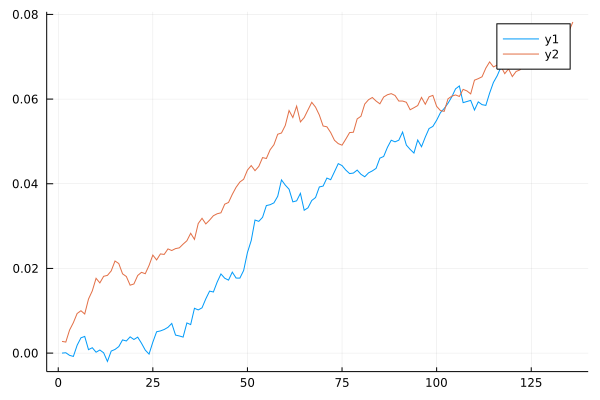

In [863]:
t_stop = size(mat_pos)[1]
pnl = sum(lag(mat_pos)[2:end,:] .* ret[w:end-1-(dict_ini["t_step"]-2)-1,:], dims=2)

sr = mean(pnl) / std(pnl) * 15.87
println("SR: ", sr)


pos = mat_pos
to = sum(sum(abs.(diff(pos, dims=1)), dims=2)[1:end-1]) ./ sum(sum(abs.(pos), dims=2)[1:end-1])
println("TO ", to*100)

bias = sum(pnl) ./ sum(sum(abs.(mat_pos), dims=2), dims=1)[1] * 10^4
println("BIAS (bps): ", bias)

println("BIAS / TO (bps) ", bias / to)

plot(cumsum(pnl, dims=1))
plot!(cumsum(pnl_ini_net[2:end], dims=1))

### adding perturbation in the prediction

- with standard noise => does not directly affect the accuracy

In [845]:
dict_param = Dict()
#dict_param["alpha"] = 1
#dict_param["level_min"] = 0.000
dict_param["level_max"] = 0.01
dict_param["cost"] = 5
#dict_param["lambda"] = 0.2
#dict_param["cost"] = 0.05
dict_param["to"] = 0.1

#dict_param["outperf"] = 0
#dict_param["bound"] = 0.01
#dict_param["tracking"] = 0

dict_ini = Dict()
dict_ini["n_asset"] = n_universe
dict_ini["t_step"] = 10

mat_pos = zero(n_universe)
mat_cov = cov(ret)

t_trading = size(ret_pred_target)[1]

x_prev = zeros(n_universe)
sig = 0.001
for k=1:t_trading
    #v_ret = ret_pred[k,:]
    v_ret = ret_pred_target[k:k+dict_ini["t_step"]-1,:]
    for t=2:dict_ini["t_step"]
        #sig += 1*10^-3
        v_ret[t,:] = v_ret[t,:] .+  rand(Normal(0, sig), n_universe)
    end
    #x_opt = opt_pf(v_ret, mat_cov, dict_param);
    #x_opt = opt_pf_to(v_ret, mat_cov, dict_param, x_prev);
    #x_ini = pos_ini_target[k,:]
    #x_opt = opt_pf_toBIS(v_ret, mat_cov, dict_param, x_prev, x_ini)
    #x_opt = multi_opt(v_ret, dict_ini, dict_param)
    x_opt = multi_opt_trans(v_ret, dict_ini, dict_param, x_prev)
    x_opt = x_opt[1,:]
    x_prev = x_opt
    mat_pos = vcat(mat_pos, reshape(x_opt, (1, n_universe)))
end

Academic license - for non-commercial use only - expires 2021-07-08
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 7580 rows, 5210 columns and 23280 nonzeros
Model fingerprint: 0x09fbf210
Coefficient statistics:
  Matrix range     [5e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+00]
Presolve removed 3781 rows and 1440 columns
Presolve time: 0.01s
Presolved: 3799 rows, 3770 columns, 14560 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    6957    6.0001445e-02   0.000000e+00   0.000000e+00      0s

Solved in 6957 iterations and 0.20 seconds
Optimal objective  6.000144483e-02

User-callback calls 7004, time in user-callback 0.00 sec
Academic license - for non-commercial use only - expires 2021-07-08
Gurobi Optimizer version 9.1.0 b

LoadError: [91mBoundsError: attempt to access 127×130 Array{Float64,2} at index [119:128, 1:130][39m

SR: 7.494034863673299
TO 10.547429627459396
BIAS (bps): 8.530931545300787
BIAS / TO (bps) 80.88161615310695


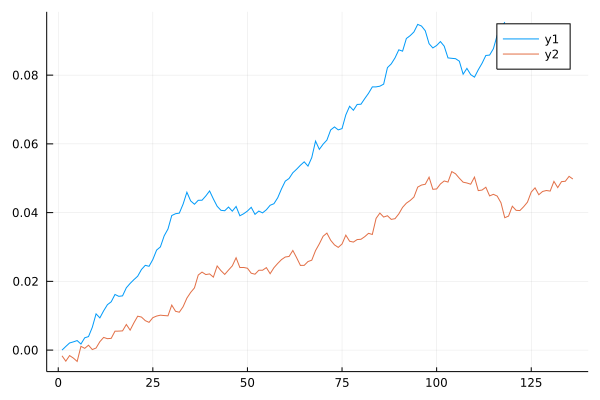

In [846]:
t_stop = size(mat_pos)[1]
pnl = sum(lag(mat_pos)[2:end,:] .* ret[w:end-1-(dict_ini["t_step"]-2)-1,:], dims=2)

sr = mean(pnl) / std(pnl) * 15.87
println("SR: ", sr)


pos = mat_pos
to = sum(sum(abs.(diff(pos, dims=1)), dims=2)[1:end-1]) ./ sum(sum(abs.(pos), dims=2)[1:end-1])
println("TO ", to*100)

bias = sum(pnl) ./ sum(sum(abs.(mat_pos), dims=2), dims=1)[1] * 10^4
println("BIAS (bps): ", bias)

println("BIAS / TO (bps) ", bias / to)

plot(cumsum(pnl, dims=1))
plot!(cumsum(pnl_ini_net[2:end], dims=1))

### directly changing the accuracy

In [850]:
dict_param = Dict()
#dict_param["alpha"] = 1
#dict_param["level_min"] = 0.000
dict_param["level_max"] = 0.01
dict_param["cost"] = 5
#dict_param["lambda"] = 0.2
#dict_param["cost"] = 0.05
dict_param["to"] = 0.1

#dict_param["outperf"] = 0
#dict_param["bound"] = 0.01
#dict_param["tracking"] = 0

dict_ini = Dict()
dict_ini["n_asset"] = n_universe
dict_ini["t_step"] = 10

mat_pos = zero(n_universe)
mat_cov = cov(ret)

t_trading = size(ret_pred_target)[1]

x_prev = zeros(n_universe)
sig = 0.001
for k=1:t_trading
    #v_ret = ret_pred[k,:]
    v_ret = ret_pred_target[k:k+dict_ini["t_step"]-1,:]
    for t=2:dict_ini["t_step"]
        #sig += 1*10^-3
        #v_ret[t,:] = v_ret[t,:] .+  rand(Normal(0, sig), n_universe)
        acc_level = 0.9
        ind = rand(Binomial(1, acc_level), n_universe);
        v_ret_t = v_ret[t,:]
        v_ret_t[ind .==0] .= -v_ret_t[ind .==0];
        v_ret[t,:] = v_ret_t
    end
    #x_opt = opt_pf(v_ret, mat_cov, dict_param);
    #x_opt = opt_pf_to(v_ret, mat_cov, dict_param, x_prev);
    #x_ini = pos_ini_target[k,:]
    #x_opt = opt_pf_toBIS(v_ret, mat_cov, dict_param, x_prev, x_ini)
    #x_opt = multi_opt(v_ret, dict_ini, dict_param)
    x_opt = multi_opt_trans(v_ret, dict_ini, dict_param, x_prev)
    x_opt = x_opt[1,:]
    x_prev = x_opt
    mat_pos = vcat(mat_pos, reshape(x_opt, (1, n_universe)))
end

Academic license - for non-commercial use only - expires 2021-07-08
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 7580 rows, 5210 columns and 23280 nonzeros
Model fingerprint: 0xef3a41ad
Coefficient statistics:
  Matrix range     [3e-05, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+00]
Presolve removed 3781 rows and 1440 columns
Presolve time: 0.01s
Presolved: 3799 rows, 3770 columns, 14560 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    7127    5.9380325e-02   0.000000e+00   0.000000e+00      0s

Solved in 7127 iterations and 0.19 seconds
Optimal objective  5.938032529e-02

User-callback calls 7174, time in user-callback 0.00 sec
Academic license - for non-commercial use only - expires 2021-07-08
Gurobi Optimizer version 9.1.0 b

LoadError: [91mBoundsError: attempt to access 127×130 Array{Float64,2} at index [119:128, 1:130][39m

SR: 6.940278973351836
TO 10.78937661379569
BIAS (bps): 8.325471597783098
BIAS / TO (bps) 77.16360171483721


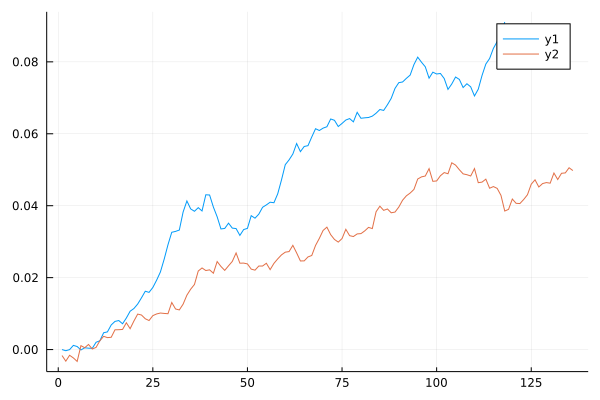

In [851]:
t_stop = size(mat_pos)[1]
pnl = sum(lag(mat_pos)[2:end,:] .* ret[w:end-1-(dict_ini["t_step"]-2)-1,:], dims=2)

sr = mean(pnl) / std(pnl) * 15.87
println("SR: ", sr)


pos = mat_pos
to = sum(sum(abs.(diff(pos, dims=1)), dims=2)[1:end-1]) ./ sum(sum(abs.(pos), dims=2)[1:end-1])
println("TO ", to*100)

bias = sum(pnl) ./ sum(sum(abs.(mat_pos), dims=2), dims=1)[1] * 10^4
println("BIAS (bps): ", bias)

println("BIAS / TO (bps) ", bias / to)

plot(cumsum(pnl, dims=1))
plot!(cumsum(pnl_ini_net[2:end], dims=1))

# Question: 
- should I agregate before / after ? 
- Shoudl I 

In [ ]:
""" Test simple Markovitz one days with a minimum level"""

vec_ret = ret_pred[17,:]
mat_cov = cov(ret);

lambda = 0.0
#alpha_min = 1 / n_universe^2
alpha_min = 0.0001

#model = Model(Gurobi.Optimizer)
model = Model(() -> Gurobi.Optimizer(GRB_ENV))

@variable(model, x[i=1:n_universe])
@variable(model, y[i=1:n_universe])

# AVOINDING BEING TOO CONCENTRATED
@constraint(model, [i=1:n_universe], y[i] >= alpha_min)

# INVEST 1 DOLLARS IN ABSOLUTE VALUE
@constraint(model,[i=1:n_universe], y[i]>=x[i])
@constraint(model,[i=1:n_universe], y[i]>=-x[i])
@constraint(model, sum(y[i] for i=1:n_universe) == 1)

# BEING DOLLAR NEUTRAL
@constraint(model, sum(x[i] for i=1:n_universe) == 0)

# MEAN-VAR PORTFOLIO
@objective(model, Max, vec_ret'x - lambda * sum(x[i] * (mat_cov*x)[i] for i=1:n_universe))

optimize!(model);

a = getvalue.(x);
a

# Remark and problems:
- with independant asset (no correlation) + no correlation between prediction => markovitz useless => provide a very concentrated asset on only 1 asset => does not expoite LLN 